#The Ellipsoids
Before presenting the Löwner-John ellipsoids let me briefly fix some notations. An ellipsoid $E$ in the $n$ -dimensional Euclidean space $\mathbb{R}^{n}$ is the image of the unit ball $B_{n}$,
i.e., the ball of radius 1 centered at the origin, under a regular affine transformation. So there exist a $t \in \mathbb{R}^{n}$, the center of the ellipsoid, and a regular matrix $T \in \mathbb{R}^{n \times n}$ such that
$(1)$
$$
E=t+T B_{n}=\left\{t+T y: y \in B_{n}\right\}
$$
$$
=\left\{x \in \mathbb{R}^{n}:\left\|T^{-1}(x-t)\right\| \leq 1\right\}
$$
where $\|\cdot\|$ denotes the Euclidean norm. By standard compactness arguments it can be easily seen that every convex body $K \subset \mathbb{R}^{n}$, i.e., convex compact set with interior points, has an inscribed and circumscribed ellipsoid of maximal and minimal volume, respectively. To prove, however,
FIGURE 1. Maximal inscribed ellipse of a flat diamond, and minimal circumscribed ellipse (circle) of a regular triangle.

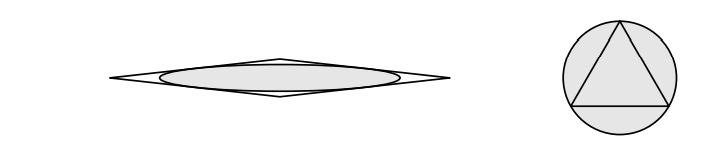

FIGURE 1. Maximal inscribed ellipse of a flat diamond, and minimal circumscribed ellipse (circle) of a regular triangle.

$(2)$
$$
t+\frac{1}{n} T B_{n} \subset K \subseteq t+T B_{n}
$$
In other words, $K$ can be sandwiched between two concentric ellipsoids of ratio $n$. According to Harold W. Kuhn [28], the geometric problem (2) and related questions from convex geometry were John's main motivation for his paper [24]. John also pointed out that for convex bodies having a center of symmetry, i.e., there exists a $c \in \mathbb{R}^{n}$ such that $K=c-K=\{c-y: y \in K\}$, the factor $1 / n$ can be replaced by $1 / \sqrt{n}$ and that both bounds are best possible as a simplex and a cube show.

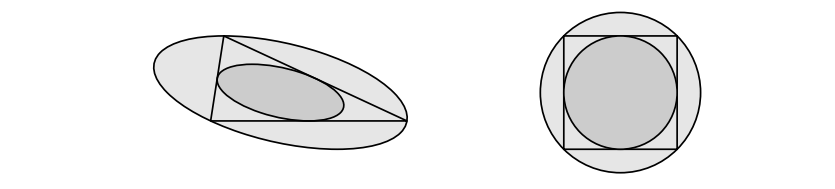
FIGURE 2. Minimal volume ellipses together with their concentric copies scaled by $\frac{1}{2}$ for the triangle and by $\frac{1}{\sqrt{2}}$ for the square.


In [7]:
# Figures 8.3 and 8.4, pages 412 and 416.
# Ellipsoidal approximations.

from math import log, pi
from cvxopt import blas, lapack, solvers, matrix, sqrt, mul, cos, sin
solvers.options['show_progress'] = False
try: import pylab
except ImportError: pylab_installed = False
else: pylab_installed = True


In [8]:
# Extreme points (with first one appended at the end)
X = matrix([ 0.55,  0.25, -0.20, -0.25,  0.00,  0.40,  0.55,
             0.00,  0.35,  0.20, -0.10, -0.30, -0.20,  0.00 ], (7,2))
m = X.size[0] - 1

# Inequality description G*x <= h with h = 1
G, h = matrix(0.0, (m,2)), matrix(0.0, (m,1))
G = (X[:m,:] - X[1:,:]) * matrix([0., -1., 1., 0.], (2,2))
h = (G * X.T)[::m+1]
G = mul(h[:,[0,0]]**-1, G)
h = matrix(1.0, (m,1))



In [9]:
# Loewner-John ellipsoid
#
# minimize     log det A^-1
# subject to   xk'*A*xk - 2*xk'*b + b'*A^1*b <= 1,  k=1,...,m
#
# 5 variables x = (A[0,0], A[1,0], A[1,1], b[0], b[1])

def F(x=None, z=None):
    if x is None:
        return m, matrix([ 1.0, 0.0, 1.0, 0.0, 0.0 ])

    # Factor A as A = L*L'.  Compute inverse B = A^-1.
    A = matrix( [x[0], x[1], x[1], x[2]], (2,2))
    L = +A
    try: lapack.potrf(L)
    except: return None
    B = +L
    lapack.potri(B)
    B[0,1] = B[1,0]

    # f0 = -log det A
    f = matrix(0.0, (m+1,1))
    f[0] = -2.0 * (log(L[0,0]) + log(L[1,1]))

    # fk = xk'*A*xk - 2*xk'*b + b*A^-1*b - 1
    #    = (xk - c)' * A * (xk - c) - 1  where c = A^-1*b
    c = x[3:]
    lapack.potrs(L, c)
    for k in range(m):
        f[k+1] = (X[k,:].T - c).T * A * (X[k,:].T - c) - 1.0

    # gradf0 = (-A^-1, 0) = (-B, 0)
    Df = matrix(0.0, (m+1,5))
    Df[0,0], Df[0,1], Df[0,2] = -B[0,0], -2.0*B[1,0], -B[1,1]

    # gradfk = (xk*xk' - A^-1*b*b'*A^-1,  2*(-xk + A^-1*b))
    #        = (xk*xk' - c*c', 2*(-xk+c))
    Df[1:,0] = X[:m,0]**2 - c[0]**2
    Df[1:,1] = 2.0 * (mul(X[:m,0], X[:m,1]) - c[0]*c[1])
    Df[1:,2] = X[:m,1]**2 - c[1]**2
    Df[1:,3] = 2.0 * (-X[:m,0] + c[0])
    Df[1:,4] = 2.0 * (-X[:m,1] + c[1])

    if z is None: return f, Df

    # hessf0(Y, y) = (A^-1*Y*A^-1, 0) = (B*YB, 0)
    H0 = matrix(0.0, (5,5))
    H0[0,0] = B[0,0]**2
    H0[1,0] = 2.0 * B[0,0] * B[1,0]
    H0[2,0] = B[1,0]**2
    H0[1,1] = 2.0 * ( B[0,0] * B[1,1] + B[1,0]**2 )
    H0[2,1] = 2.0 * B[1,0] * B[1,1]
    H0[2,2] = B[1,1]**2

    # hessfi(Y, y)
    #     = ( A^-1*Y*A^-1*b*b'*A^-1 + A^-1*b*b'*A^-1*Y*A^-1
    #             - A^-1*y*b'*A^-1 - A^-1*b*y'*A^-1,
    #         -2*A^-1*Y*A^-1*b + 2*A^-1*y )
    #     = ( B*Y*c*c' + c*c'*Y*B - B*y*c' - c*y'*B,  -2*B*Y*c + 2*B*y )
    #     = ( B*(Y*c-y)*c' + c*(Y*c-y)'*B, -2*B*(Y*c - y) )
    H1 = matrix(0.0, (5,5))
    H1[0,0] = 2.0 * c[0]**2 * B[0,0]
    H1[1,0] = 2.0 * ( c[0] * c[1] * B[0,0] + c[0]**2 * B[1,0] )
    H1[2,0] = 2.0 * c[0] * c[1] * B[1,0]
    H1[3:,0] = -2.0 * c[0] * B[:,0]
    H1[1,1] = 2.0 * c[0]**2 * B[1,1] + 4.0 * c[0]*c[1]*B[1,0]  + \
              2.0 * c[1]**2 + B[0,0]
    H1[2,1] = 2.0 * (c[1]**2 * B[1,0] + c[0]*c[1]*B[1,1])
    H1[3:,1] = -2.0 * B * c[[1,0]]
    H1[2,2] = 2.0 * c[1]**2 * B[1,1]
    H1[3:,2] = -2.0 * c[1] * B[:,1]
    H1[3:,3:] = 2*B

    return f, Df, z[0]*H0 + sum(z[1:])*H1

sol = solvers.cp(F)
A = matrix( sol['x'][[0, 1, 1, 2]], (2,2))
b = sol['x'][3:]

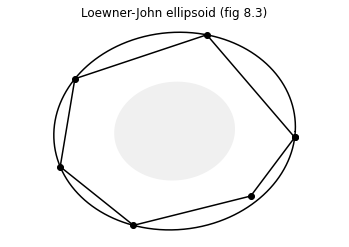

In [10]:
if pylab_installed:
    pylab.figure(1, facecolor='w')
    pylab.plot(X[:,0], X[:,1], 'ko', X[:,0], X[:,1], '-k')

    # Ellipsoid in the form { x | || L' * (x-c) ||_2 <= 1 }
    L = +A
    lapack.potrf(L)
    c = +b
    lapack.potrs(L, c)

    # 1000 points on the unit circle
    nopts = 1000
    angles = matrix( [ a*2.0*pi/nopts for a in range(nopts) ], (1,nopts) )
    circle = matrix(0.0, (2,nopts))
    circle[0,:], circle[1,:] = cos(angles), sin(angles)

    # ellipse = L^-T * circle + c
    blas.trsm(L, circle, transA='T')
    ellipse = circle + c[:, nopts*[0]]
    ellipse2 = 0.5 * circle + c[:, nopts*[0]]

    pylab.plot(ellipse[0,:].T, ellipse[1,:].T, 'k-')
    pylab.fill(ellipse2[0,:].T, ellipse2[1,:].T, facecolor = '#F0F0F0')
    pylab.title('Loewner-John ellipsoid (fig 8.3)')
    pylab.axis('equal')
    pylab.axis('off')

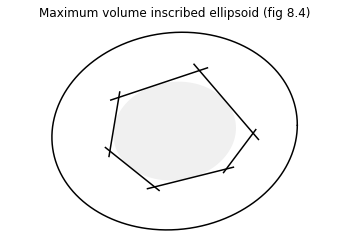

In [11]:
# Maximum volume enclosed ellipsoid
#
# minimize    -log det B
# subject to  ||B * gk||_2 + gk'*c <= hk,  k=1,...,m
#
# with variables  B and c.
#
# minimize    -log det L
# subject to  ||L' * gk||_2^2 / (hk - gk'*c) <= hk - gk'*c,  k=1,...,m
#
# L lower triangular with positive diagonal and B*B = L*L'.
#
# minimize    -log x[0] - log x[2]
# subject to   g( Dk*x + dk ) <= 0,  k=1,...,m
#
# g(u,t) = u'*u/t - t
# Dk = [ G[k,0]   G[k,1]  0       0        0
#        0        0       G[k,1]  0        0
#        0        0       0      -G[k,0]  -G[k,1] ]
# dk = [0; 0; h[k]]
#
# 5 variables x = (L[0,0], L[1,0], L[1,1], c[0], c[1])

D = [ matrix(0.0, (3,5)) for k in range(m) ]
for k in range(m):
    D[k][ [0, 3, 7, 11, 14] ] = matrix( [G[k,0], G[k,1], G[k,1],
        -G[k,0], -G[k,1]] )
d = [matrix([0.0, 0.0, hk]) for hk in h]

def F(x=None, z=None):
    if x is None:
        return m, matrix([ 1.0, 0.0, 1.0, 0.0, 0.0 ])
    if min(x[0], x[2], min(h-G*x[3:])) <= 0.0:
        return None

    y = [ Dk*x + dk for Dk, dk in zip(D, d) ]

    f = matrix(0.0, (m+1,1))
    f[0] = -log(x[0]) - log(x[2])
    for k in range(m):
        f[k+1] = y[k][:2].T * y[k][:2] / y[k][2] - y[k][2]

    Df = matrix(0.0, (m+1,5))
    Df[0,0], Df[0,2] = -1.0/x[0], -1.0/x[2]

    # gradient of g is ( 2.0*(u/t);  -(u/t)'*(u/t) -1)
    for k in range(m):
        a = y[k][:2] / y[k][2]
        gradg = matrix(0.0, (3,1))
        gradg[:2], gradg[2] = 2.0 * a, -a.T*a - 1
        Df[k+1,:] =  gradg.T * D[k]
    if z is None: return f, Df

    H = matrix(0.0, (5,5))
    H[0,0] = z[0] / x[0]**2
    H[2,2] = z[0] / x[2]**2

    # Hessian of g is (2.0/t) * [ I, -u/t;  -(u/t)',  (u/t)*(u/t)' ]
    for k in range(m):
        a = y[k][:2] / y[k][2]
        hessg = matrix(0.0, (3,3))
        hessg[0,0], hessg[1,1] = 1.0, 1.0
        hessg[:2,2], hessg[2,:2] = -a,  -a.T
        hessg[2, 2] = a.T*a
        H += (z[k] * 2.0 / y[k][2]) *  D[k].T * hessg * D[k]

    return f, Df, H

sol = solvers.cp(F)
L = matrix([sol['x'][0], sol['x'][1], 0.0, sol['x'][2]], (2,2))
c = matrix([sol['x'][3], sol['x'][4]])

if pylab_installed:
    pylab.figure(2, facecolor='w')

    # polyhedron
    for k in range(m):
        edge = X[[k,k+1],:] + 0.1 * matrix([1., 0., 0., -1.], (2,2)) * \
            (X[2*[k],:] - X[2*[k+1],:])
        pylab.plot(edge[:,0], edge[:,1], 'k')


    # 1000 points on the unit circle
    nopts = 1000
    angles = matrix( [ a*2.0*pi/nopts for a in range(nopts) ], (1,nopts) )
    circle = matrix(0.0, (2,nopts))
    circle[0,:], circle[1,:] = cos(angles), sin(angles)

    # ellipse = L * circle + c
    ellipse = L * circle + c[:, nopts*[0]]
    ellipse2 = 2.0 * L * circle + c[:, nopts*[0]]

    pylab.plot(ellipse2[0,:].T, ellipse2[1,:].T, 'k-')
    pylab.fill(ellipse[0,:].T, ellipse[1,:].T, facecolor = '#F0F0F0')
    pylab.title('Maximum volume inscribed ellipsoid (fig 8.4)')
    pylab.axis('equal')
    pylab.axis('off')

    pylab.show()

## References
(C) Copyright 2004-2021, Martin S. Andersen, Joachim Dahl, and Lieven Vandenberghe.. Last updated on Feb $18,2021 .$
Built with Sphinx using a theme provided by Read the Docs.